In [1]:
import numpy as np
import torch
import cv2
from dm_control import suite

import lib_duju.utils as duju_utils

from Model.ReplayBuffer import ReplayBuffer
from Model.FrameBuffer import FrameBuffer
from Model.SAC_base import target_initialize

from Model.DiscreteConv_SAC import DiscreteConvSAC
from Model.DiscreteConv_SAC import train_discrete_Conv_SAC

exp_title = "Conv_Discrete_SAC"

env = suite.load(domain_name="cartpole",task_name="swingup")

action_dim = 5

# state related variables
step_size = 4
channel_size = 3
height = 48
width = 64

input_channel_size = step_size * channel_size

action_dict = { 0 : -1.0,
               1 : -0.5,
               2 : 0.0,
               3 : 0.5,
               4 : 1.0 }

reward_compensate = 10 # inverse alpha

lr = 1e-3
gamma = 0.99
device = torch.device("cuda")
max_episode = 10000
batch_size = 100

replay_buffer = ReplayBuffer(buffer_size=5e4)
frame_buffer = FrameBuffer(step_size, channel_size, height, width)

q_main = DiscreteConvSAC(step_size, channel_size, height, width, action_dim, lr, device)
q_target = DiscreteConvSAC(step_size, channel_size, height, width, action_dim, lr, device)

target_initialize(q_main, q_target)

In [2]:
for epi_i in range(1, max_episode + 1):
    print(epi_i)

    timestep = env.reset()
    ep_reward = 0.0

    # timestep, reward, discount, observation
    end, _, _, _ = timestep
    end = end.last()

    frame = env.physics.render(camera_id=0, height = 48, width = 64)
    for _ in range(step_size):
        frame_buffer.dm_add(frame)
    s = frame_buffer.get_buffer()

    while not end:
        a_category = q_main.get_stochastic_action(
                        torch.FloatTensor(s).to(device).view(1, input_channel_size, height, width)
                                                  )
        a_deploy = action_dict[a_category]
        timestep = env.step(a_deploy)

        end, r, _, _ = timestep
        end = end.last()
        frame = env.physics.render(camera_id=0, height=48, width=64)
        frame_buffer.dm_add(frame)

        s2 = frame_buffer.get_buffer()

        replay_buffer.add(s, np.array([a_category]), np.array([r * reward_compensate]),np.array([end]), s2)

#         frame = env.physics.render(camera_id=0, height=480, width=640)  # [height, width, channel]
#         cv2.imshow("train", frame)
#         cv2.waitKey(1)

        s = s2
        ep_reward += r

    for _idx in range(1000):
        #print(_idx)
        max_q1, max_q2 = train_discrete_Conv_SAC(q_main, q_target, replay_buffer, batch_size, gamma)

    print(ep_reward, "***", (max_q1, max_q2))

    #### Eval ####

    timestep = env.reset()
    eval_ep_reward = 0.0
    eval_action = []

    end, _, _, _ = timestep
    end = end.last()

    frame = env.physics.render(camera_id=0, height=48, width=64)
    for _ in range(step_size):
        frame_buffer.dm_add(frame)
    s = frame_buffer.get_buffer()

    if (epi_i % 1) == 0 :
        while not end:
            a_category = q_main.get_max_action(
                        torch.FloatTensor(s).to(device).view(1, input_channel_size, height, width)
                                                  )
            a_deploy = action_dict[a_category]
            eval_action.append(a_deploy)

            timestep = env.step(a_deploy)

            end, r, _, _ = timestep
            end = end.last()
            frame = env.physics.render(camera_id=0, height=48, width=64)
            frame_buffer.dm_add(frame)

            s2 = frame_buffer.get_buffer()

            s = s2
            eval_ep_reward += r

#             frame = env.physics.render(camera_id=0, height=480, width=640) #[height, width, channel]
#             cv2.imshow("eval", frame)
#             cv2.waitKey(1)


        print("Eval! *** ", eval_ep_reward)
        #print(eval_action)

    if (epi_i % 10) == 0:
        print("Networks Saved!")
        duju_utils.torch_network_save(q_main,"../trained/"+exp_title+"_q_main_"+str(epi_i)+".torch")
        duju_utils.torch_network_save(q_target, "../trained/"+exp_title+"_q_target_"+str(epi_i)+".torch")

# cv2.destroyAllWindows()

1
43.92829730679916 *** (tensor(5.4126, device='cuda:0'), tensor(5.4978, device='cuda:0'))
Eval! ***  74.95863704069737
2
56.83881831965524 *** (tensor(8.5296, device='cuda:0'), tensor(8.5125, device='cuda:0'))
Eval! ***  132.78542407914176
3


KeyboardInterrupt: 

In [2]:
env.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('position', array([-0.00910449, -0.99988647,  0.01506803])), ('velocity', array([-0.00998568,  0.01624428]))]))

In [3]:
import matplotlib.pyplot as plt

In [73]:
t = env.physics.render(camera_id=0, height = 48, width = 64)

In [74]:
frame_buffer.dm_add(t)

In [75]:
k = frame_buffer.get_buffer()

In [80]:
kk = k[-3:]

In [81]:
kkk = np.array((kk + 1.0) * 128,dtype=np.int32)
kkk = np.moveaxis(kkk, [0,1,2], [2,0,1])
kkk.shape

(48, 64, 3)

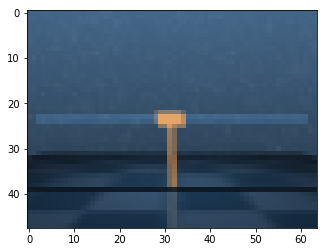

In [82]:
plt.imshow(kkk)

In [20]:
duju_utils.torch_network_load(q_main,"trained/Conv_Discrete_SAC_q_main_200.torch")

In [21]:
import torch.nn.functional as F

In [95]:
action_dict = {
    0 : -1.0,
    1 : -0.5,
    2 : 0.0,
    3 : 0.5,
    4 : 1.0
}

In [100]:
env.reset()
rc = 0.0
for _ in range(1000):
    t = env.physics.render(camera_id=0, height = 48, width = 64)
    frame_buffer.dm_add(t)
    k = frame_buffer.get_buffer()
    
    input_ = torch.FloatTensor(k.reshape([1,12,48,64])).to(device)

    a1 = q_main.q1_conv1(input_)
    a1

    aa1 = F.relu(a1)
    aa1

    a2 = q_main.q1_conv2(aa1)
    aa2 = F.relu(a2)

    a3 = q_main.q1_conv3(aa2)
    aa3 = F.relu(a3)

    fc1 = aa3.view(1,-1)

    f1 = q_main.q1_fc1(fc1)
    ff1 = F.relu(f1)

    f2 = q_main.q1_fc2(ff1)
    ff2 = f2

    action = int(torch.argmax(ff2))
    action = action_dict[action]
    _, r, _, _ = env.step(action)
    rc +=r
    
    
    print(ff2, action)
print(rc)

tensor([[106.4008, 145.0679, 144.0928, 130.6144, 145.3407]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[ 95.8856, 133.8708, 135.3447, 121.8102, 139.2920]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[47.0991, 55.8349, 56.7008, 53.5641, 57.4301]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[37.0125, 36.7968, 37.0401, 37.2182, 36.6362]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.5
tensor([[36.5125, 36.2539, 36.4639, 36.5716, 36.1271]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.5
tensor([[36.7280, 36.3356, 36.5941, 36.6251, 36.2672]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[35.7307, 35.2793, 35.6042, 35.6060, 35.1911]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[34.7784, 34.3194, 34.6558, 34.6128, 34.2663]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[34.3922, 33.9478, 34.2752, 34.2014, 33.8961]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tenso

tensor([[40.5273, 41.3892, 40.9054, 40.7778, 41.1158]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[45.1068, 46.7641, 45.8672, 46.2260, 46.1937]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[47.8249, 50.0153, 48.9144, 49.5835, 49.2922]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[50.0470, 52.0758, 51.0207, 51.8468, 51.6136]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[45.1569, 46.5928, 45.7868, 46.1489, 46.1267]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[44.3996, 45.6364, 44.8755, 45.1427, 45.1885]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[45.3884, 46.8387, 45.9998, 46.2943, 46.3952]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[44.8101, 46.2841, 45.4228, 45.8004, 45.6399]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[46.6222, 48.5108, 47.4837, 48.1643, 47.8396]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[4

       grad_fn=<AddmmBackward>) -1.0
tensor([[36.9725, 36.5510, 36.8710, 36.5816, 36.6686]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[33.4798, 33.3049, 33.3038, 33.0637, 33.2646]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[33.4996, 33.3999, 33.2560, 32.9780, 33.1788]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[32.9079, 32.8515, 32.6570, 32.4732, 32.5711]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[34.4628, 34.5699, 34.3346, 34.2452, 34.1460]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[33.5342, 33.4611, 33.0452, 32.9147, 33.0488]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[35.4812, 35.2696, 34.8009, 34.7687, 34.8678]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[40.6713, 40.2982, 40.1500, 40.2291, 39.9563]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[46.1936, 46.0422, 46.1946, 45.9932, 45.1821]], device='cuda:0',
       gra

tensor([[78.6187, 79.2814, 79.2049, 77.3332, 79.7872]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[83.2665, 84.3816, 83.7671, 81.6193, 83.9047]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[84.5599, 85.7760, 85.6578, 83.4665, 85.0079]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[85.5232, 86.3229, 85.5720, 84.5032, 85.9801]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[84.3907, 85.9954, 85.5747, 84.5809, 85.6986]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5
tensor([[81.4996, 82.8000, 82.3123, 81.8896, 82.8630]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[83.1133, 84.4507, 83.5859, 83.6840, 84.9925]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[85.3778, 86.2203, 84.6983, 85.3618, 86.7666]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[92.4099, 93.2382, 92.3674, 92.1111, 93.6415]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[95.397

tensor([[257.9077, 255.8697, 259.1931, 255.5415, 263.8650]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[253.6099, 252.4972, 256.2912, 252.5010, 259.4800]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[241.6462, 241.3905, 245.6482, 241.5788, 247.7375]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[237.0887, 237.2150, 241.7230, 238.2767, 243.3488]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[222.4848, 222.7749, 226.8957, 223.4970, 228.3405]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[222.4226, 222.8024, 226.9046, 223.0042, 227.5858]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[229.9545, 231.3111, 235.1820, 231.3593, 235.9032]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[226.3317, 227.9927, 231.7075, 227.9028, 232.3940]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[226.7407, 227.8011, 231.6133, 227.9955, 232.6927]], device='cuda:0',
       gra

       grad_fn=<AddmmBackward>) 0.0
tensor([[279.2551, 281.3238, 283.0943, 274.7690, 276.0292]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[272.1421, 275.1783, 276.6121, 267.4767, 267.2281]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[277.4146, 280.5061, 281.8136, 272.5696, 271.4331]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[273.4718, 276.1866, 277.2286, 269.4059, 268.1937]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[269.1963, 270.8268, 272.0647, 264.5874, 264.4481]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[253.6525, 256.0768, 257.8622, 250.0917, 249.5885]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[236.6146, 239.8952, 242.2599, 234.5469, 233.1746]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[239.3072, 239.6119, 245.7334, 239.0641, 238.9624]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[243.2275, 244.7665, 253.6779, 244.9596, 244

       grad_fn=<AddmmBackward>) -1.0
tensor([[203.5031, 194.5098, 190.9958, 190.0235, 198.5249]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[196.5835, 188.9102, 191.3764, 187.2820, 192.0103]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[179.3359, 175.9983, 175.3589, 173.1476, 176.8903]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[183.8371, 181.9980, 178.7821, 177.8428, 179.0506]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[175.8246, 185.0176, 187.7930, 178.3998, 171.6608]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[182.8137, 185.1479, 186.5942, 183.8388, 178.4761]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[179.9359, 177.3457, 174.8249, 179.7713, 176.6395]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[200.9194, 200.6761, 193.9885, 200.5508, 195.6823]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[194.9656, 198.6026, 198.8166, 202.31

tensor([[103.4739, 103.6429, 104.0394, 106.1676, 102.8752]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.5
tensor([[108.5928, 109.2259, 109.4234, 111.0998, 107.6223]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.5
tensor([[110.7191, 111.7176, 111.8381, 113.8826, 109.7801]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.5
tensor([[109.3362, 111.2235, 110.7942, 113.6949, 109.2556]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.5
tensor([[106.2332, 108.2798, 108.0302, 110.2825, 106.4331]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.5
tensor([[106.7015, 109.3455, 109.1874, 110.1165, 107.3153]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.5
tensor([[100.7194, 103.3192, 103.4167, 103.3582, 101.3459]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[105.0199, 107.4317, 107.8970, 108.7333, 104.2062]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.5
tensor([[104.4946, 106.9945, 107.4420, 107.7534, 103.7942]], device='cuda:0',
       gra

tensor([[194.7469, 201.2334, 200.3026, 198.0089, 201.9049]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[189.7119, 189.7207, 188.4823, 187.8793, 189.9350]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[195.2122, 184.1297, 182.8880, 194.1905, 195.9263]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[194.4201, 177.8847, 177.5735, 193.3593, 194.1117]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[193.7019, 179.6593, 179.1050, 190.2934, 191.1171]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[185.3249, 177.5101, 179.9964, 180.3140, 179.6978]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[189.1285, 185.8275, 187.8281, 184.8395, 183.4716]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[188.5658, 185.5150, 186.7994, 186.1201, 184.1719]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[176.4842, 173.8902, 174.4825, 174.9899, 173.7868]], device='cuda:0',
     

tensor([[91.0755, 86.3516, 88.9924, 88.3702, 88.1425]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[90.6207, 86.5639, 89.4669, 88.4298, 88.0584]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[90.0999, 85.5679, 89.4393, 88.0696, 87.4412]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[100.1588,  95.4445,  99.6423,  97.9399,  97.9639]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0
tensor([[101.7510,  98.1873, 102.2274,  99.0899,  99.4338]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[106.0712, 102.9502, 106.4749, 102.5446, 103.1176]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[107.5983, 105.9577, 108.3888, 105.0372, 105.6527]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[112.7845, 111.6644, 113.3306, 109.9519, 111.1318]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0
tensor([[111.0632, 110.0159, 111.2651, 108.3312, 109.3652]], device='cuda:0',
       grad_fn=<Addmm

tensor([[119.9920, 123.9588, 119.9207, 121.5060, 124.8626]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[125.3272, 131.0030, 128.0244, 123.9904, 134.2849]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[118.1367, 121.6512, 124.0935, 120.0181, 127.1263]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[114.3735, 115.9713, 116.7383, 115.5622, 121.3489]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[125.5989, 129.4170, 126.3229, 128.1497, 133.8268]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[150.4930, 158.7850, 152.9601, 158.7101, 164.2502]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[136.5166, 144.5465, 136.0547, 143.1105, 150.0089]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[121.3152, 127.0427, 119.8148, 127.0615, 130.6463]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0
tensor([[136.0475, 146.9486, 145.1175, 147.2589, 156.0901]], device='cuda:0',
       gra

In [96]:

input_ = torch.FloatTensor(k.reshape([1,12,48,64])).to(device)

a1 = q_main.q1_conv1(input_)
a1

aa1 = F.relu(a1)
aa1

a2 = q_main.q1_conv2(aa1)
aa2 = F.relu(a2)

a3 = q_main.q1_conv3(aa2)
aa3 = F.relu(a3)

fc1 = aa3.view(1,-1)

f1 = q_main.q1_fc1(fc1)
ff1 = F.relu(f1)

f2 = q_main.q1_fc2(ff1)
ff2 = f2

action = int(torch.argmax(ff2))
action = action_dict[action]
env.step(action)

In [97]:
action

3

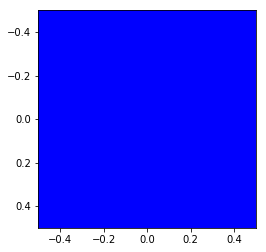

In [116]:
test_image = np.array([
    [[0,0,0]],  
])
test_image.shape

plt.imshow(test_image)

In [132]:
kkk = kkk / 256

In [133]:
kkkk = kkk[:,:,0] * 0.2989 + kkk[:,:,1] * 0.5870 + kkk[:,:,2] * 0.1140

In [140]:
frame = env.physics.render(camera_id=0, height = 48, width = 64)

In [141]:
frame.shape

(48, 64, 3)

In [142]:
frame = frame / 256.0
frame = frame[:,:,[0]] * 0.2989 + frame[:,:,[1]] * 0.5870 + frame[:,:,[2]] * 0.1140
frame = np.moveaxis(frame, [0, 1, 2], [1, 2, 0])

In [144]:
frame.shape

(1, 48, 64)

In [134]:
kkkk.shape

(48, 64)

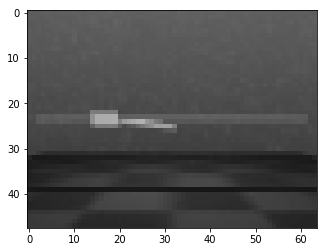

In [145]:
plt.imshow(frame[0], cmap=plt.get_cmap('gray'), vmin=0,vmax=1)